In [12]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter("runs/simple_classification")

**1. DATA PREPROCESSING**

We will first load all the images from the [dataset](https://www.kaggle.com/datasets/xainano/handwrittenmathsymbols).

In [13]:
# Load the dataset and make a random rotation
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomRotation(15, fill=255),  # Fill the border with white pixels
    transforms.ToTensor()])
dataset = datasets.ImageFolder("data/data/extracted_images", transform=transform)

Since there are many images we will only use at first a subset of them, with all classes present in both training and testing. For this we use a method found at aux_functions.

In [20]:
from sklearn.model_selection import train_test_split
from aux_functions import get_subset_with_all_labels
from torch.utils.data import Subset

# Get a subset with all labels present
subset = get_subset_with_all_labels(dataset, 10_000, 10, True)

# Get labels from the subset
subset_labels = [subset[i][1] for i in range(len(subset))]

# Perform stratified splitting
indices = np.arange(len(subset))
train_indices, test_indices = train_test_split(
    indices, 
    test_size=0.2, 
    stratify=subset_labels,
    random_state=42
)

train_subset = Subset(subset, train_indices)
test_subset = Subset(subset, test_indices)

# Dataloader for training and testing
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=32, shuffle=True)

Completed label: 0/82
Completed label: 1/82
Completed label: 2/82
Completed label: 3/82
Completed label: 4/82
Completed label: 5/82
Completed label: 6/82
Completed label: 7/82
Completed label: 8/82
Completed label: 9/82
Completed label: 10/82
Completed label: 11/82
Completed label: 12/82
Completed label: 13/82
Completed label: 14/82
Completed label: 15/82
Completed label: 16/82
Completed label: 17/82
Completed label: 18/82
Completed label: 19/82
Completed label: 20/82
Completed label: 21/82
Completed label: 22/82
Completed label: 23/82
Completed label: 24/82
Completed label: 25/82
Completed label: 26/82
Completed label: 27/82
Completed label: 28/82
Completed label: 29/82
Completed label: 30/82
Completed label: 31/82
Completed label: 32/82
Completed label: 33/82
Completed label: 34/82
Completed label: 35/82
Completed label: 36/82
Completed label: 37/82
Completed label: 38/82
Completed label: 39/82
Completed label: 40/82
Completed label: 41/82
Completed label: 42/82
Completed label: 43/8

Now we explore the data checking that it has been correctly preprocessed.

Length of training set: 8000
Length of testing set: 2000


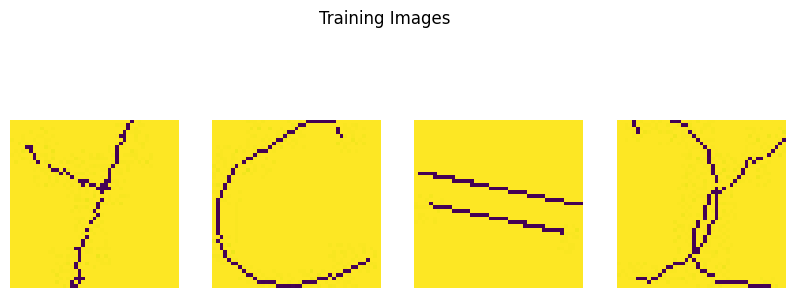

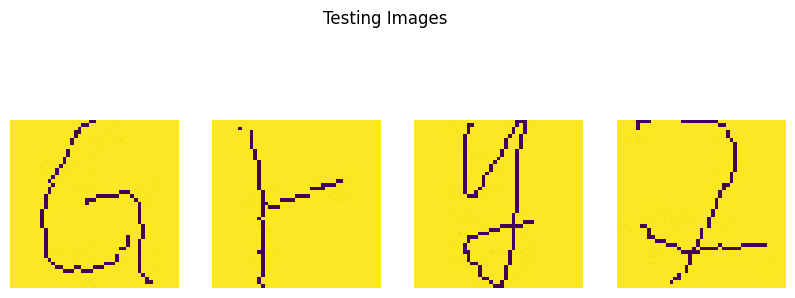

In [21]:
print(f"Length of training set: {len(train_subset)}")
print(f"Length of testing set: {len(test_subset)}")

# Testing data loader
train_images, train_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))

# Plotting training images
fig1, axes1 = plt.subplots(figsize=(10,4), ncols=4)
for i in range(4):
    ax = axes1[i]
    ax.imshow(train_images[i].permute(1, 2, 0))
    ax.axis("off")
fig1.suptitle("Training Images")
plt.show()

# Plotting testing images
fig2, axes2 = plt.subplots(figsize=(10,4), ncols=4)
for i in range(4):
    ax = axes2[i]
    ax.imshow(test_images[i].permute(1, 2, 0))
    ax.axis("off")
fig2.suptitle("Testing Images")
plt.show()


img_grid = torchvision.utils.make_grid(test_images)
writer.add_image("symbols", img_grid)


**2. SIMPLE MODEL CREATION AND TRAINING**

We create a simple CNN at first with 2 convolutional layers and 3 fully connected layers. It will serve as a benchmark to how complex this classification is.

In [22]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 9 * 9, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 82)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

first_cnn = SimpleCNN().to(device)

Now we will train the model in the subset we created previously

In [23]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(first_cnn.parameters(), lr=0.001)
scaler = torch.amp.GradScaler("cuda")
writer.add_graph(first_cnn, test_images.to(device))

In [24]:
accumulation_steps = 4
n_epochs = 30
n_total_steps = len(train_loader)

running_loss = 0.0
running_correct = 0
for epoch in range(n_epochs):
    first_cnn.train()

    for i, (images, labels) in enumerate(train_loader, 0):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast("cuda"): 
            outputs = first_cnn(images)
            loss = criterion(outputs, labels) / accumulation_steps

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:  # Update after accumulation
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()

        if (i+1) % 100 == 0:
            print(f"Epoch[{epoch+1}/{n_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}")
            writer.add_scalar("training_loss", running_loss/100, epoch * n_total_steps + i)
            writer.add_scalar("training_accuracy", running_correct/100, epoch * n_total_steps + i)
            running_loss = 0.0
            running_correct = 0



print("Finished training")

Epoch[1/30], Step [100/250], Loss: 0.9931
Epoch[1/30], Step [200/250], Loss: 0.9417
Epoch[2/30], Step [100/250], Loss: 0.8041
Epoch[2/30], Step [200/250], Loss: 0.6631
Epoch[3/30], Step [100/250], Loss: 0.6589
Epoch[3/30], Step [200/250], Loss: 0.5930
Epoch[4/30], Step [100/250], Loss: 0.4540
Epoch[4/30], Step [200/250], Loss: 0.4907
Epoch[5/30], Step [100/250], Loss: 0.3913
Epoch[5/30], Step [200/250], Loss: 0.4858
Epoch[6/30], Step [100/250], Loss: 0.3914
Epoch[6/30], Step [200/250], Loss: 0.3314
Epoch[7/30], Step [100/250], Loss: 0.3698
Epoch[7/30], Step [200/250], Loss: 0.3185
Epoch[8/30], Step [100/250], Loss: 0.2928
Epoch[8/30], Step [200/250], Loss: 0.2452
Epoch[9/30], Step [100/250], Loss: 0.1430
Epoch[9/30], Step [200/250], Loss: 0.3791
Epoch[10/30], Step [100/250], Loss: 0.1982
Epoch[10/30], Step [200/250], Loss: 0.2555
Epoch[11/30], Step [100/250], Loss: 0.1862
Epoch[11/30], Step [200/250], Loss: 0.2695
Epoch[12/30], Step [100/250], Loss: 0.2822
Epoch[12/30], Step [200/250],

In [25]:
labels = []
preds = []

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels1 in test_loader:
        images, labels1 = images.to(device), labels1.to(device)
        outputs = first_cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels1.size(0)
        n_correct += (predicted == labels1).sum().item()

        class_predictions = [F.softmax(output, dim=0) for output in outputs]

        preds.append(class_predictions)
        labels.append(predicted)

preds = torch.cat([torch.stack(batch) for batch in preds])
labels = torch.cat(labels)

acc = 100.0 * n_correct / n_samples
print(f"Accuracy on the test set: {acc} %")

label_mapping = {v: k for k, v in dataset.class_to_idx.items()}

classes = range(82)
for i in classes: 
    labels_i = labels == i
    preds_i = preds[:, i]
    writer.add_pr_curve(label_mapping[i], labels_i, preds_i, global_step=0)
    writer.close()

Accuracy on the test set: 79.5 %
